Episode 1/1000, Total Reward: -2173.954762934651
Episode 2/1000, Total Reward: -2173.954762934651
Episode 3/1000, Total Reward: -2173.954762934651
Episode 4/1000, Total Reward: -2173.954762934651
Episode 5/1000, Total Reward: -2173.954762934651
Episode 6/1000, Total Reward: -2173.954762934651
Episode 7/1000, Total Reward: -2172.1027629346504
Episode 8/1000, Total Reward: -2173.954762934651
Episode 9/1000, Total Reward: -2172.1027629346504
Episode 10/1000, Total Reward: -2173.954762934651
Episode 11/1000, Total Reward: -2173.57476293465
Episode 12/1000, Total Reward: -2150.3747629346494
Episode 13/1000, Total Reward: -2173.171762934651
Episode 14/1000, Total Reward: -2173.57476293465
Episode 15/1000, Total Reward: -2205.2947629346504
Episode 16/1000, Total Reward: -2173.954762934651
Episode 17/1000, Total Reward: -2173.491762934651
Episode 18/1000, Total Reward: -2173.954762934651
Episode 19/1000, Total Reward: -2173.954762934651
Episode 20/1000, Total Reward: -2146.5687629346485
Episod

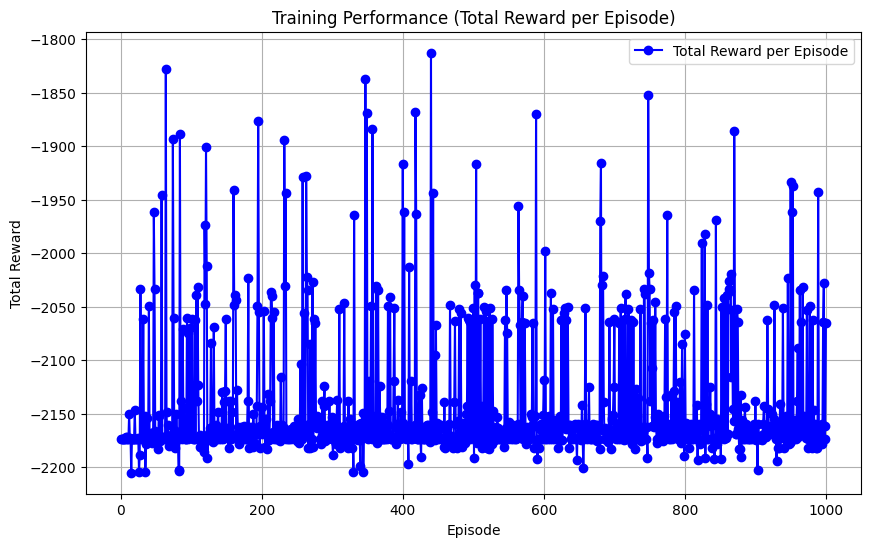

In [11]:
import numpy as np
import traci
import matplotlib.pyplot as plt

# --- Parameters ---
NUM_EPISODES = 1000
MAX_STEPS = 1000
EPSILON = 0.1  # Exploration rate
GAMMA = 0.9    # Discount factor
ALPHA = 0.1    # Learning rate
num_actions = 2  # Number of traffic light phases
q_table = np.zeros((10, 10, 10, 10, 10, num_actions))  # Q-table with discretized state space
episode_rewards = []

# --- Discretization Helper ---
def discretize(value, bins, min_val, max_val):
    """Discretize a value into a range of bins."""
    value = max(min_val, min(value, max_val))  # Clamp to [min_val, max_val]
    return int((value - min_val) / (max_val - min_val) * (bins - 1))

def get_discretized_state():
    """Fetch the current state and discretize it."""
    state = [
        discretize(traci.edge.getLastStepHaltingNumber("E5"), 10, 0, 50),  # Halting vehicles (0 to 50)
        discretize(traci.edge.getLastStepHaltingNumber("E4"), 10, 0, 50),
        discretize(traci.edge.getLastStepMeanSpeed("E0"), 10, 0, 30),      # Speed (0 to 30)
        discretize(traci.edge.getWaitingTime("E4"), 10, 0, 100),          # Waiting time (0 to 100)
        discretize(traci.edge.getWaitingTime("E5"), 10, 0, 100),
    ]
    return tuple(state)

# --- Reward Function ---
def calculate_reward():
    """Calculate the reward based on traffic metrics."""
    ramp_waiting_time = traci.edge.getWaitingTime("E5")  # Example: waiting time on ramp
    highway_flow = traci.edge.getLastStepMeanSpeed("E0")  # Example: speed on highway
    max_ramp_waiting = 50  # Example: max ramp waiting time
    max_highway_speed = 30  # Example: max highway speed

    normalized_rwt = ramp_waiting_time / max_ramp_waiting
    normalized_hf = highway_flow / max_highway_speed

    # Weights for reward components
    alpha = 1.0
    beta = 1.0

    reward = -alpha * normalized_rwt + beta * normalized_hf

    # Penalty for extreme congestion
    if ramp_waiting_time > max_ramp_waiting * 0.8:
        reward -= 10

    return reward

# --- Q-learning Functions ---
def choose_action(state):
    """Epsilon-greedy policy to select an action."""
    if np.random.rand() < EPSILON:
        return np.random.randint(num_actions)  # Random action
    else:
        return np.argmax(q_table[state])  # Best action from Q-table

def update_q_table(state, action, reward, next_state):
    """Update the Q-table using the Q-learning formula."""
    current_q = q_table[state + (action,)]
    next_max_q = np.max(q_table[next_state])  # Get the max Q-value for the next state
    q_table[state + (action,)] = current_q + ALPHA * (reward + GAMMA * next_max_q - current_q)

# --- Training Loop ---
for episode in range(NUM_EPISODES):
    traci.start(["sumo", "-c", "sumo_config/simulation.sumocfg"])  # Update path to your SUMO config
    state = get_discretized_state()
    total_reward = 0

    for step in range(MAX_STEPS):
        action = choose_action(state)
        try:
            traci.trafficlight.setPhase("J7", action)  # Update to your traffic light ID
        except traci.exceptions.TraCIException as e:
            print(f"Error: {e}")
            break

        traci.simulationStep()  # Advance simulation

        next_state = get_discretized_state()
        reward = calculate_reward()

        update_q_table(state, action, reward, next_state)
        total_reward += reward
        state = next_state

        if traci.simulation.getMinExpectedNumber() <= 0:  # Simulation ends
            break

    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1}/{NUM_EPISODES}, Total Reward: {total_reward}")
    traci.close()

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, label="Total Reward per Episode", color="blue", marker="o")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance (Total Reward per Episode)")
plt.legend()
plt.grid(True)
plt.show()
